In [16]:
%pip install open_clip_torch

In [2]:
import os
import json
import torch
from PIL import Image
import open_clip
import tarfile

In [18]:
# 경로 설정
origin_folder = 'Laion_origin'
output_folder = 'Laion_imgs'

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 00101.tar ~ 00200.tar까지 반복
for i in range(108, 130):
    tar_name = f"{i:05d}.tar"
    tar_path = os.path.join(origin_folder, tar_name)

    if os.path.exists(tar_path):
        print(f"Extracting {tar_name}...")
        try:
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=output_folder)
        except Exception as e:
            print(f"Error extracting {tar_name}: {e}")
    else:
        print(f"{tar_name} not found!")

Extracting 00108.tar...
Error extracting 00108.tar: [Errno 13] Permission denied: 'Laion_imgs\\001080117.jpg'
Extracting 00109.tar...
Error extracting 00109.tar: [Errno 13] Permission denied: 'Laion_imgs\\001090000.jpg'
Extracting 00110.tar...
Error extracting 00110.tar: [Errno 13] Permission denied: 'Laion_imgs\\001100002.jpg'
Extracting 00111.tar...
Error extracting 00111.tar: [Errno 13] Permission denied: 'Laion_imgs\\001110000.jpg'
Extracting 00112.tar...
Error extracting 00112.tar: [Errno 13] Permission denied: 'Laion_imgs\\001120207.jpg'
Extracting 00113.tar...
Error extracting 00113.tar: [Errno 13] Permission denied: 'Laion_imgs\\001130244.jpg'
Extracting 00114.tar...
Error extracting 00114.tar: [Errno 13] Permission denied: 'Laion_imgs\\001140143.jpg'
Extracting 00115.tar...
Error extracting 00115.tar: [Errno 13] Permission denied: 'Laion_imgs\\001150003.jpg'
Extracting 00116.tar...
Error extracting 00116.tar: [Errno 13] Permission denied: 'Laion_imgs\\001160086.jpg'
Extracting

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [19]:
# 모델 및 변환기 초기화
model, _, preprocess_val = open_clip.create_model_and_transforms(
    'hf-hub:timm/vit_base_patch16_clip_224.laion400m_e32'
)
tokenizer = open_clip.get_tokenizer(
    'hf-hub:timm/vit_base_patch16_clip_224.laion400m_e32'
)

# 이미지 폴더 경로 설정
image_folder = r"Laion_imgs"

def classify_images(folder_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # 사용할 라벨 정의
    labels = [
        "accessories, products, hiking", "diagrams", "appliances", "outdoors, sea, sky", "products, cups, lamps, plates, candles",
        "book covers", "product photos, chairs, furniture", "text, buttons, cartoons (with text)", "person", "video game graphics",
        "toys, stuffed animals, cartoon characters", "outdoors, trees, mountains, nature", "screenshots, graphics, phone, desktop", "cars, racing", "sports",
        "outside, buildings", "jewelry, bracelet, necklace, ring, earring", "movie posters, tv shows, DVDs", "jackets, shirts, product photos", "christmas",
        "gadgets, electronics, laptops", "people on tv, movies", "people, crowds, crowded", "tires, bikes, vehicles", "food",
        "industrial, equipment", "historical photos, black and white", "holiday, flowers, wedding, birthday, cake", "political photos", "backgrounds, textures",
        "shoes, footwear, belts", "album covers", "product packaging", "weddings, wedding dress, wedding photography, couples", "sports footage",
        "celebrities", "text, book covers", "makeup, perfume, product", "sexy, porn", "travel, destinations, famous buildings",
        "normal cars", "cellphones, cellphone cases", "video game covers, comic books, superheroes", "girl, family, baby, people", "invitations, events, venues",
        "art, paintings, frames", "clothing, models, product photography", "parts, tools", "posters, ads, book covers, movies", "flowers, garden, plants",
        "vehicles - trains, planes, trucks, heavy equipment, satellites", "text, forms, documents, sheet music", "business, graphics, infographics, presentations", "signs, products",
        "shorts, pants, skirts, product photography", "Indian", "animals", "watches clocks, time, timepieces", "drinks, bottles, alcohol",
        "people, text", "text, graphs, study materials", "interior, furniture, bedroom, bathroom, bed, sofa", "logos, stickers, graphics", "products, shirts, hats"
    ]

    text_inputs = tokenizer(labels)
    text_inputs = text_inputs.to(device)
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGB")
            image = preprocess_val(image).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                top_label = labels[similarity.argmax().item()]

                result = {"label": top_label}
                json_path = os.path.join(folder_path, filename.replace(".jpg", "_result.json"))
                with open(json_path, "w", encoding="utf-8") as f:
                    json.dump(result, f, ensure_ascii=False, indent=4)

                print(f"Processed {filename}: {top_label}")

if __name__ == "__main__":
    classify_images(image_folder)


Processed 001080020.jpg: sports
Processed 001080029.jpg: signs, products
Processed 001080055.jpg: person
Processed 001080087.jpg: album covers
Processed 001080117.jpg: food
Processed 001080136.jpg: person
Processed 001080138.jpg: tires, bikes, vehicles
Processed 001080139.jpg: person
Processed 001080145.jpg: sports
Processed 001080146.jpg: sports
Processed 001080148.jpg: sports
Processed 001080151.jpg: sports
Processed 001080156.jpg: book covers
Processed 001080206.jpg: sports
Processed 001080227.jpg: logos, stickers, graphics
Processed 001080231.jpg: person
Processed 001080236.jpg: backgrounds, textures
Processed 001080243.jpg: person
Processed 001080249.jpg: sports
Processed 001080256.jpg: person
Processed 001080266.jpg: movie posters, tv shows, DVDs
Processed 001080278.jpg: christmas
Processed 001080281.jpg: person
Processed 001080282.jpg: sports
Processed 001080283.jpg: flowers, garden, plants
Processed 001080300.jpg: sports
Processed 001080310.jpg: sports
Processed 001080338.jpg: 

KeyboardInterrupt: 

In [2]:
import os
import json
import torch
from PIL import Image
import open_clip
from collections import Counter

class ImageClassifier:
    def __init__(self, model_name, labels, image_folder):
        self.model_name = model_name
        self.labels = labels
        self.image_folder = image_folder
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # 모델 및 변환기 초기화
        self.model, _, self.preprocess_val = open_clip.create_model_and_transforms(self.model_name)
        self.tokenizer = open_clip.get_tokenizer(self.model_name)
        self.model.to(self.device)
        self.model.eval()

    def classify_images(self):
        text_inputs = self.tokenizer(self.labels)
        text_inputs = text_inputs.to(self.device)
        text_features = self.model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for filename in os.listdir(self.image_folder):
            if filename.endswith(".jpg"):
                image_path = os.path.join(self.image_folder, filename)
                with Image.open(image_path).convert("RGB") as img:
                    image = self.preprocess_val(img).unsqueeze(0).to(self.device)
                # image = self.preprocess_val(image).unsqueeze(0).to(self.device)

                with torch.no_grad():
                    image_features = self.model.encode_image(image)
                    image_features /= image_features.norm(dim=-1, keepdim=True)

                    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                    top_label = self.labels[similarity.argmax().item()]

                    result = {"label": top_label}
                    json_path = os.path.join(self.image_folder, filename.replace(".jpg", "_result.json"))
                    with open(json_path, "w", encoding="utf-8") as f:
                        json.dump(result, f, ensure_ascii=False, indent=4)

                    print(f"Processed {filename}: {top_label}")
        return self.image_folder


class LabelRemover:
    def __init__(self, image_folder):
        self.image_folder = image_folder

    def safe_remove(self, path):
        import stat
        import time
        import gc

        try:
            if os.path.exists(path):
                os.chmod(path, stat.S_IWRITE)
                gc.collect()
                time.sleep(0.1)
                os.remove(path)
                print(f"Deleted: {path}")
        except PermissionError as e:
            print(f"[PermissionError] {path} 삭제 실패: {e}")
        except Exception as e:
            print(f"[Error] {path} 삭제 실패: {e}")

    def remove_indian_labeled_images(self):
        for filename in os.listdir(self.image_folder):
            if filename.endswith("_result.json"):
                json_path = os.path.join(self.image_folder, filename)

                with open(json_path, 'r', encoding='utf-8') as f:
                    result = json.load(f)

                if result["label"] == "Indian":
                    image_path = os.path.join(self.image_folder, filename.replace("_result.json", ".jpg"))
                    txt_path = os.path.join(self.image_folder, filename.replace("_result.json", ".txt"))
                    original_json_path = os.path.join(self.image_folder, filename.replace("_result.json", ".json"))

                    self.safe_remove(image_path)
                    self.safe_remove(json_path)
                    self.safe_remove(txt_path)
                    self.safe_remove(original_json_path)



class LabelCounter:
    def __init__(self, image_folder):
        self.image_folder = image_folder

    def count_labels(self):
        label_counter = Counter()

        for filename in os.listdir(self.image_folder):
            if filename.endswith("_result.json"):
                json_path = os.path.join(self.image_folder, filename)

                # JSON 파일 읽기
                with open(json_path, 'r', encoding='utf-8') as f:
                    result = json.load(f)

                # 라벨 카운트
                label = result["label"]
                label_counter[label] += 1

        # 라벨별 개수 출력
        for label, count in label_counter.items():
            print(f"Label: {label}, Count: {count}")


if __name__ == "__main__":

    image_folder = r"Laion_imgs"

    remover = LabelRemover(image_folder=image_folder)
    remover.remove_indian_labeled_images()


    # 라벨 카운트
    counter = LabelCounter(image_folder=image_folder)
    counter.count_labels()


Deleted: Laion_imgs\001083214.jpg
Deleted: Laion_imgs\001083214_result.json
Deleted: Laion_imgs\001083214.txt
Deleted: Laion_imgs\001083214.json
Deleted: Laion_imgs\001083215.jpg
Deleted: Laion_imgs\001083215_result.json
Deleted: Laion_imgs\001083215.txt
Deleted: Laion_imgs\001083215.json
Deleted: Laion_imgs\001083221.jpg
Deleted: Laion_imgs\001083221_result.json
Deleted: Laion_imgs\001083221.txt
Deleted: Laion_imgs\001083221.json
Deleted: Laion_imgs\001083232.jpg
Deleted: Laion_imgs\001083232_result.json
Deleted: Laion_imgs\001083232.txt
Deleted: Laion_imgs\001083232.json
Deleted: Laion_imgs\001083233.jpg
Deleted: Laion_imgs\001083233_result.json
Deleted: Laion_imgs\001083233.txt
Deleted: Laion_imgs\001083233.json
Deleted: Laion_imgs\001083242.jpg
Deleted: Laion_imgs\001083242_result.json
Deleted: Laion_imgs\001083242.txt
Deleted: Laion_imgs\001083242.json
Deleted: Laion_imgs\001083266.jpg
Deleted: Laion_imgs\001083266_result.json
Deleted: Laion_imgs\001083266.txt
Deleted: Laion_imgs\

KeyboardInterrupt: 

In [4]:
import os
import json
import shutil

class LabelBasedOrganizer:
    def __init__(self, base_folder):
        self.base_folder = base_folder

    def organize_by_label(self):
        for filename in os.listdir(self.base_folder):
            if not filename.endswith("_result.json"):
                continue

            result_path = os.path.join(self.base_folder, filename)

            # JSON 열기
            with open(result_path, 'r', encoding='utf-8') as f:
                result = json.load(f)

            label = result.get("label")
            if not label:
                print(f"[경고] 라벨이 없는 파일: {filename}")
                continue

            prefix = filename.replace("_result.json", "")
            label_folder = os.path.join(self.base_folder, label)

            # 라벨 폴더가 없다면 생성
            os.makedirs(label_folder, exist_ok=True)

            # 관련된 모든 파일 이동 (.jpg, .json, .txt, _result.json)
            for ext in [".jpg", ".json", ".txt", "_result.json"]:
                src = os.path.join(self.base_folder, f"{prefix}{ext}")
                dst = os.path.join(label_folder, f"{prefix}{ext}")
                if os.path.exists(src):
                    try:
                        if os.path.exists(dst):
                            os.remove(dst)  # 기존 파일 삭제
                        shutil.move(src, dst)
                        print(f"Moved {src} → {dst}")
                    except Exception as e:
                        print(f"[오류] {src} 이동 실패: {e}")


In [5]:
import re

def sanitize_filename(name):
    # 윈도우 불가능 문자 제거 / -> _, : -> -, etc
    return re.sub(r'[<>:"/\\|?*]', '_', name)

## Data 분배

In [10]:
import os
import shutil
import random
from collections import defaultdict

LABEL_DIR = "Laion_imgs"
CLIENT_ROOT = "clients"
NUM_CLIENTS = 20
LABELS_PER_CLIENT = 9
TOTAL_IMAGES_PER_CLIENT = 500
OVERLAP_LABELS = 4

random.seed(42)

# 모든 라벨 폴더
all_labels = [folder for folder in os.listdir(LABEL_DIR) if os.path.isdir(os.path.join(LABEL_DIR, folder))]
random.shuffle(all_labels)

# 클라이언트별 라벨 셋 할당
client_labels = defaultdict(set)

# 1. 라벨을 겹치게 할당
for i in range(NUM_CLIENTS):
    client_labels[i] = set(random.sample(all_labels, LABELS_PER_CLIENT))

# 라벨 겹치기
for i in range(NUM_CLIENTS - 1):
    shared = random.sample(list(client_labels[i]), OVERLAP_LABELS)
    client_labels[i + 1].update(shared)

# 2. 클라이언트별로 데이터 복사
os.makedirs(CLIENT_ROOT, exist_ok=True)

for cid in range(NUM_CLIENTS):
    client_path = os.path.join(CLIENT_ROOT, f"client_{cid}")
    os.makedirs(client_path, exist_ok=True)

    print(f"📦 Client {cid} 라벨: {client_labels[cid]}")
    images_copied = 0
    used_labels = list(client_labels[cid])
    random.shuffle(used_labels)

    for label in used_labels:
        label_path = os.path.join(LABEL_DIR, label)
        if not os.path.isdir(label_path):
            continue

        files = [f for f in os.listdir(label_path) if f.endswith(".jpg")]
        random.shuffle(files)
        count = 0
        for img_file in files:
            base = img_file.replace(".jpg", "")
            group = [f"{base}.jpg", f"{base}.txt"]
            if all(os.path.exists(os.path.join(label_path, f)) for f in group):
                # 👉 라벨 이름 정제 적용
                safe_label = sanitize_filename(label)
                dst_dir = os.path.join(client_path, safe_label)
                os.makedirs(dst_dir, exist_ok=True)
                for f in group:
                    src = os.path.join(label_path, f)
                    dst = os.path.join(dst_dir, f)
                    shutil.copy(src, dst) # 이미 존재하면 Permission error - 신경 안 써도 ok
                count += 1
                images_copied += 1
                if images_copied >= TOTAL_IMAGES_PER_CLIENT:
                    break
        if images_copied >= TOTAL_IMAGES_PER_CLIENT:
            break



📦 Client 0 라벨: {'video game graphics', 'toys, stuffed animals, cartoon characters', 'celebrities', 'historical photos, black and white', 'backgrounds, textures', 'weddings, wedding dress, wedding photography, couples', 'video game covers, comic books, superheroes', 'product photos, chairs, furniture', 'signs, products'}


PermissionError: [Errno 13] Permission denied: 'clients\\client_0\\video game covers, comic books, superheroes\\001286453.jpg'

## 클라이언트 내 데이터셋 분할(training/ validation/ test)

In [ ]:
def split_dataset(client_dir):
    for label in os.listdir(client_dir):
        label_path = os.path.join(client_dir, label)
        if not os.path.isdir(label_path):
            continue
        files = sorted([f for f in os.listdir(label_path) if f.endswith(".jpg")])
        random.shuffle(files)

        total = len(files)
        train_end = int(total * 0.7)
        val_end = int(total * 0.85)

        for idx, f in enumerate(files):
            base = f.replace(".jpg", "")
            dest = "train" if idx < train_end else "val" if idx < val_end else "test"
            target_path = os.path.join(client_dir, dest, label)
            os.makedirs(target_path, exist_ok=True)

            for ext in [".jpg", ".txt"]:
                shutil.move(
                    os.path.join(label_path, f"{base}{ext}"),
                    os.path.join(target_path, f"{base}{ext}")
                )
        shutil.rmtree(label_path)

# 예시: 모든 클라이언트 데이터 분할
for i in range(NUM_CLIENTS):
    split_dataset(os.path.join(CLIENT_ROOT, f"client_{i}"))


## 트랜스포머 설치

In [1]:
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.40.2
!pip install accelerate
!pip install scikit-learn
!pip install seaborn

Looking in indexes: https://download.pytorch.org/whl/cu121


  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached tokenizers-0.19.1-cp310-none-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
Using cached tokenizers-0.19.1-cp310-none-win_amd64.whl (2.2 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1


## 로컬 모델 정의 + 학습

In [69]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

In [70]:
!pip show torch

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\user\miniconda3\envs\laion_env\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, open_clip_torch, timm, torchaudio, torchvision


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### multimodal dataset

In [72]:
# ---------------------------
# 1. 데이터셋 정의
class MultiModalDataset(Dataset):
    def __init__(self, root, tokenizer, transform, label2idx):
        self.samples = []
        self.transform = transform
        self.tokenizer = tokenizer
        self.label2idx = label2idx

        for label in os.listdir(root):
            label_path = os.path.join(root, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.endswith(".jpg"):
                    base = fname[:-4]
                    txt_path = os.path.join(label_path, f"{base}.txt")
                    img_path = os.path.join(label_path, f"{base}.jpg")
                    if os.path.exists(txt_path):
                        self.samples.append((img_path, txt_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, txt_path, label = self.samples[idx]
        image = self.transform(Image.open(img_path).convert("RGB"))

        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()

        encoded = self.tokenizer(text, truncation=True, padding='max_length', max_length=32, return_tensors="pt")
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        label_idx = self.label2idx[label]
        return image, input_ids, attention_mask, torch.tensor(label_idx)

In [73]:
# ---------------------------
# 2. 인코더 정의
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.mobilenet_v3_small(pretrained=True)
        self.features = model.features  # 이건 [B, 576, H, W]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 🔥 꼭 필요!
        self.output_dim = 576

    def forward(self, x):
        x = self.features(x)          # → [B, 576, H, W]
        x = self.avgpool(x)           # → [B, 576, 1, 1]
        x = torch.flatten(x, 1)       # → [B, 576]
        return x

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("prajjwal1/bert-tiny")
        self.output_dim = self.bert.config.hidden_size

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output


In [74]:
CLIENT_MODALITY = {
    "image_only": [0, 1],
    "text_only": [2, 3],
    "both": [4, 5, 6, 7, 8, 9]
}

### fusion classifier

In [75]:
# ---------------------------
# 3. 멀티모달 분류기
class FusionClassifier(nn.Module):
    def __init__(self, fusion_input_dim, hidden_dim, num_classes, use_img=True, use_txt=True):
        super().__init__()
        self.use_img = use_img
        self.use_txt = use_txt

        if use_img:
            self.img_encoder = ImageEncoder()
        if use_txt:
            self.txt_encoder = TextEncoder()

        self.fc_fusion = nn.Linear(fusion_input_dim, hidden_dim)
        self.forget_gate = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate = nn.Linear(fusion_input_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, image, input_ids=None, attention_mask=None, prev_z=None):
        reps = []

        if self.use_img and image is not None:
            R_img = self.img_encoder(image)
            reps.append(R_img)

        if self.use_txt and input_ids is not None and attention_mask is not None:
            R_txt = self.txt_encoder(input_ids, attention_mask)
            reps.append(R_txt)

        if not reps:
            raise ValueError("[ERROR] No input modality was provided.")

        # reps가 비어있지 않은 경우에만 진행
        R = torch.cat(reps, dim=1)

        # 디버깅 추가
        # print(f"[DEBUG] use_img={self.use_img}, use_txt={self.use_txt}, R.shape={R.shape}, fc_in={self.fc_fusion.in_features}")
        assert R.shape[1] == self.fc_fusion.in_features, \
            f"[ERROR] Fusion input dim mismatch: R.shape={R.shape}, fc expects {self.fc_fusion.in_features}"

        R_prime = torch.tanh(self.fc_fusion(R))
        F_t = torch.sigmoid(self.forget_gate(prev_z))
        I_t = torch.sigmoid(self.input_gate(R))
        Z_t = F_t * prev_z + I_t * R_prime

        # print(f"[DEBUG] use_img={self.use_img}, use_txt={self.use_txt}, reps={[r.shape for r in reps]}")

        return self.classifier(Z_t), Z_t


## 학습 루프 및 평가

In [76]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for image, input_ids, attention_mask, labels in dataloader:
        image, input_ids, attention_mask, labels = image.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        batch_size = image.size(0)
        prev_z = torch.zeros(batch_size, model.classifier.in_features).to(device)

        optimizer.zero_grad()
        output, _ = model(image, input_ids, attention_mask, prev_z)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (output.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for image, input_ids, attention_mask, labels in dataloader:
            image, input_ids, attention_mask, labels = image.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            batch_size = image.size(0)
            prev_z = torch.zeros(batch_size, model.classifier.in_features).to(device)

            output, _ = model(image, input_ids, attention_mask, prev_z)
            loss = criterion(output, labels)

            total_loss += loss.item()
            correct += (output.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total


## 클라이언트 반복문으로 학습시키기

In [77]:
import json
import os

CLIENT_ROOT = "clients"
NUM_CLIENTS = 10
EPOCHS = 5
best_val_acc = 0

def train_all_clients():
    for i in range(NUM_CLIENTS):
        print(f"\n📦 Training Client {i}")
        client_path = os.path.join(CLIENT_ROOT, f"client_{i}")

        # modality 결정
        if i in CLIENT_MODALITY["image_only"]:
            use_img, use_txt = True, False
        elif i in CLIENT_MODALITY["text_only"]:
            use_img, use_txt = False, True
        else:
            use_img, use_txt = True, True

        # 라벨 매핑
        labels = sorted([l for l in os.listdir(os.path.join(client_path, "train"))
                         if os.path.isdir(os.path.join(client_path, "train", l))])
        label2idx = {label: idx for idx, label in enumerate(labels)}
        num_classes = len(label2idx)

        # 데이터셋
        train_ds = MultiModalDataset(os.path.join(client_path, "train"), tokenizer, transform, label2idx)
        val_ds = MultiModalDataset(os.path.join(client_path, "val"), tokenizer, transform, label2idx)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=16)

        fusion_input_dim = 0
        if use_img:
            fusion_input_dim += 576
        if use_txt:
            fusion_input_dim += 128

        model = FusionClassifier(
            fusion_input_dim=fusion_input_dim,
            hidden_dim=256,
            num_classes=num_classes,
            use_img=use_img,
            use_txt=use_txt
        ).to(device)
        print(f"[Client {i}] use_img={use_img}, use_txt={use_txt}, fusion_input_dim={fusion_input_dim}")

        # 모델 초기화
        # model = FusionClassifier(576, 128, 256, num_classes, use_img=use_img, use_txt=use_txt).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
        criterion = nn.CrossEntropyLoss()

        client_log = []
        # 학습 루프
        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"Client {i} Epoch {epoch+1} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            client_log.append({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

            # 가장 높은 val_acc 모델을 저장
            if epoch == 0 or val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        # ✅ 최종 best 모델 저장
        torch.save(best_model_state, os.path.join(client_path, "best_model.pt"))

        with open(os.path.join(client_path, f"training_results.json"), "w", encoding="utf-8") as f:
            json.dump(client_log, f, indent=2)


In [78]:
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [79]:
train_all_clients()


📦 Training Client 0
[Client 0] use_img=True, use_txt=False, fusion_input_dim=576
Client 0 Epoch 1 | Train Loss: 0.6517 Acc: 0.7557 | Val Loss: 0.3677 Acc: 0.8533
Client 0 Epoch 2 | Train Loss: 0.2681 Acc: 0.9138 | Val Loss: 0.1647 Acc: 0.9333
Client 0 Epoch 3 | Train Loss: 0.1214 Acc: 0.9626 | Val Loss: 0.1108 Acc: 0.9467
Client 0 Epoch 4 | Train Loss: 0.0675 Acc: 0.9885 | Val Loss: 0.0811 Acc: 0.9733
Client 0 Epoch 5 | Train Loss: 0.0558 Acc: 0.9914 | Val Loss: 0.0867 Acc: 0.9733

📦 Training Client 1
[Client 1] use_img=True, use_txt=False, fusion_input_dim=576
Client 1 Epoch 1 | Train Loss: 0.9236 Acc: 0.5702 | Val Loss: 0.7748 Acc: 0.6267
Client 1 Epoch 2 | Train Loss: 0.5402 Acc: 0.8309 | Val Loss: 0.4901 Acc: 0.8267
Client 1 Epoch 3 | Train Loss: 0.2607 Acc: 0.9169 | Val Loss: 0.3921 Acc: 0.8533
Client 1 Epoch 4 | Train Loss: 0.1256 Acc: 0.9685 | Val Loss: 0.4681 Acc: 0.8133
Client 1 Epoch 5 | Train Loss: 0.0790 Acc: 0.9799 | Val Loss: 0.4945 Acc: 0.8000

📦 Training Client 2
[Clie

## Extract Representation Vectors

In [80]:
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
from PIL import Image
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
import numpy as np
from glob import glob

## Load MiniBERT and MobileNet

In [81]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
text_model = AutoModel.from_pretrained("prajjwal1/bert-mini").to(device).eval()
text_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

weights = MobileNet_V2_Weights.DEFAULT
img_model = mobilenet_v2(weights=weights).features.to(device).eval()
img_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## 클라이언트별 representation vector 추출

In [82]:
# LAION400B 공통 데이터 디렉토리
LAION_DIR = "Laion_imgs"

# 랜덤 샘플링 설정
SAMPLE_SIZE = 500      # 전체에서 500개만 랜덤 샘플링 (시간 단축)
BATCH_SIZE = 16        # 배치 크기 (GPU 메모리에 맞게 조정)
TARGET_DIM = 512       # 공통 차원

print("파일 목록 수집 중...")
img_files = sorted(glob(os.path.join(LAION_DIR, "*.jpg")))
print(f"전체 이미지 파일: {len(img_files)}개")

# 랜덤 샘플링
if len(img_files) > SAMPLE_SIZE:
    sampled_files = random.sample(img_files, SAMPLE_SIZE)
    print(f"랜덤 샘플링: {SAMPLE_SIZE}개 선택")
else:
    sampled_files = img_files
    print(f"전체 파일 사용: {len(sampled_files)}개")

# 유효한 페어 필터링
print("유효한 이미지-텍스트 페어 확인 중...")
valid_pairs = []

for img_path in sampled_files:
    txt_path = img_path.replace(".jpg", ".txt")
    if os.path.exists(txt_path):
        try:
            if os.path.getsize(img_path) > 0 and os.path.getsize(txt_path) > 0:
                valid_pairs.append((img_path, txt_path))
        except:
            continue

print(f"유효한 페어: {len(valid_pairs)}개")

# 배치별 처리로 representation 추출
image_reps, text_reps = [], []

for i in range(0, len(valid_pairs), BATCH_SIZE):
    print(f"배치 {i//BATCH_SIZE + 1}/{(len(valid_pairs)-1)//BATCH_SIZE + 1} 처리 중...")

    batch_pairs = valid_pairs[i:i+BATCH_SIZE]
    img_batch, txt_batch = [], []

    # 배치 데이터 로드
    for img_path, txt_path in batch_pairs:
        try:
            # 이미지 로드
            image = Image.open(img_path).convert("RGB")
            img_tensor = img_preprocess(image)
            img_batch.append(img_tensor)

            # 텍스트 로드
            with open(txt_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
            if text:
                txt_batch.append(text)
            else:
                img_batch.pop()  # 빈 텍스트면 이미지도 제거

        except Exception as e:
            if len(img_batch) > len(txt_batch):
                img_batch.pop()
            continue

    if not img_batch or not txt_batch:
        continue

    try:
        # 이미지 배치 처리
        img_tensors = torch.stack(img_batch).to(device)
        with torch.no_grad():
            img_features = img_model(img_tensors).mean(dim=[2, 3])

            # 차원 맞추기
            if img_features.shape[1] > TARGET_DIM:
                img_features = img_features[:, :TARGET_DIM]
            elif img_features.shape[1] < TARGET_DIM:
                padding = torch.zeros(img_features.shape[0], TARGET_DIM - img_features.shape[1]).to(device)
                img_features = torch.cat([img_features, padding], dim=1)

        # 텍스트 배치 처리
        tokens = text_tokenizer(txt_batch, return_tensors="pt", truncation=True,
                               padding=True, max_length=512).to(device)
        with torch.no_grad():
            txt_features = text_model(**tokens).last_hidden_state.mean(dim=1)

            # 차원 맞추기
            if txt_features.shape[1] > TARGET_DIM:
                txt_features = txt_features[:, :TARGET_DIM]
            elif txt_features.shape[1] < TARGET_DIM:
                padding = torch.zeros(txt_features.shape[0], TARGET_DIM - txt_features.shape[1]).to(device)
                txt_features = torch.cat([txt_features, padding], dim=1)

        # CPU로 이동 후 저장
        image_reps.extend(img_features.cpu())
        text_reps.extend(txt_features.cpu())

    except Exception as e:
        print(f"[배치 에러]: {e}")
        continue

# 텐서화
image_reps = torch.stack(image_reps)
text_reps = torch.stack(text_reps)

print(f"최종 추출 완료:")
print(f"- 이미지 representations: {image_reps.shape}")
print(f"- 텍스트 representations: {text_reps.shape}")

파일 목록 수집 중...
전체 이미지 파일: 62053개
랜덤 샘플링: 500개 선택
유효한 이미지-텍스트 페어 확인 중...
유효한 페어: 500개
배치 1/32 처리 중...
배치 2/32 처리 중...
배치 3/32 처리 중...
배치 4/32 처리 중...
배치 5/32 처리 중...
배치 6/32 처리 중...
배치 7/32 처리 중...
배치 8/32 처리 중...
배치 9/32 처리 중...
배치 10/32 처리 중...
배치 11/32 처리 중...
배치 12/32 처리 중...
배치 13/32 처리 중...
배치 14/32 처리 중...
배치 15/32 처리 중...
배치 16/32 처리 중...
배치 17/32 처리 중...
배치 18/32 처리 중...
배치 19/32 처리 중...
배치 20/32 처리 중...
배치 21/32 처리 중...
배치 22/32 처리 중...
배치 23/32 처리 중...
배치 24/32 처리 중...
배치 25/32 처리 중...
배치 26/32 처리 중...
배치 27/32 처리 중...
배치 28/32 처리 중...
배치 29/32 처리 중...
배치 30/32 처리 중...
배치 31/32 처리 중...
배치 32/32 처리 중...
최종 추출 완료:
- 이미지 representations: torch.Size([500, 512])
- 텍스트 representations: torch.Size([500, 512])


##  KMeans + Hungarian matching으로 paired vector 생성

엘보우 방법으로 최적 k 찾는 중...
k=2: Inertia=16891.54
k=3: Inertia=16277.30
k=4: Inertia=16190.30
k=5: Inertia=15868.20
k=6: Inertia=15679.93
k=7: Inertia=15425.96
k=8: Inertia=15284.51
k=9: Inertia=15253.20
k=10: Inertia=14999.85
k=11: Inertia=14795.78
k=12: Inertia=14718.07
k=13: Inertia=14579.18
k=14: Inertia=14490.75
k=15: Inertia=14343.25
k=16: Inertia=14153.64
k=17: Inertia=14092.19
k=18: Inertia=14049.14
k=19: Inertia=13951.51
k=20: Inertia=13858.26


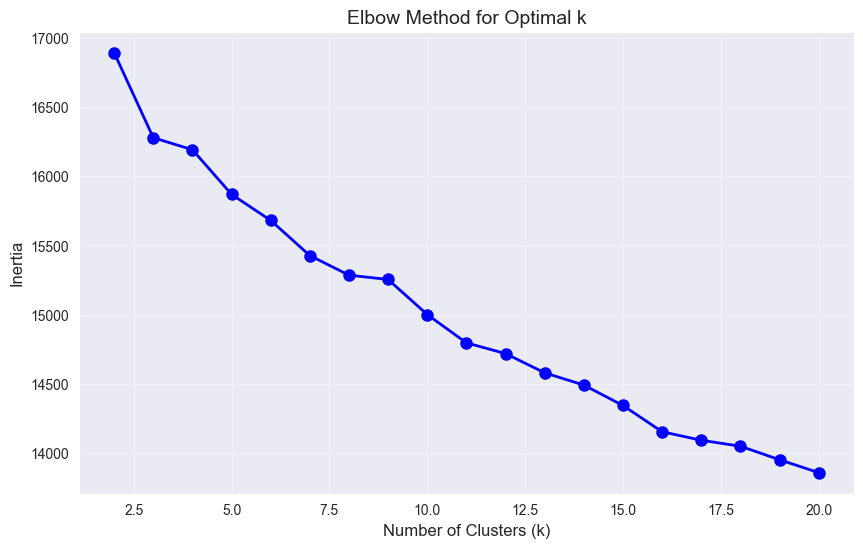

PCA 차원 축소 중...
PCA 설명 분산 비율: [0.06820171 0.06256888]
총 설명 분산: 0.131
이미지 클러스터링 애니메이션 생성 중...


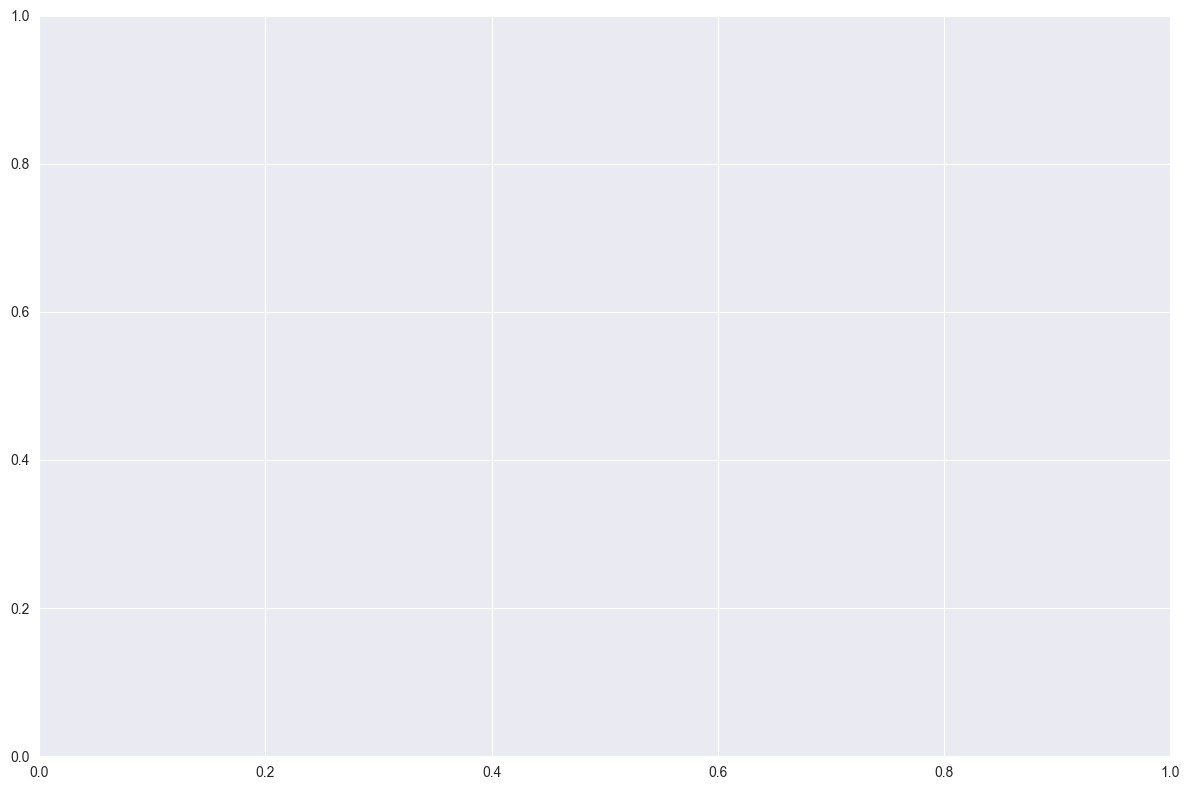

텍스트 클러스터링 애니메이션 생성 중...


C:\Users\user\miniconda3\envs\laion_env\lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


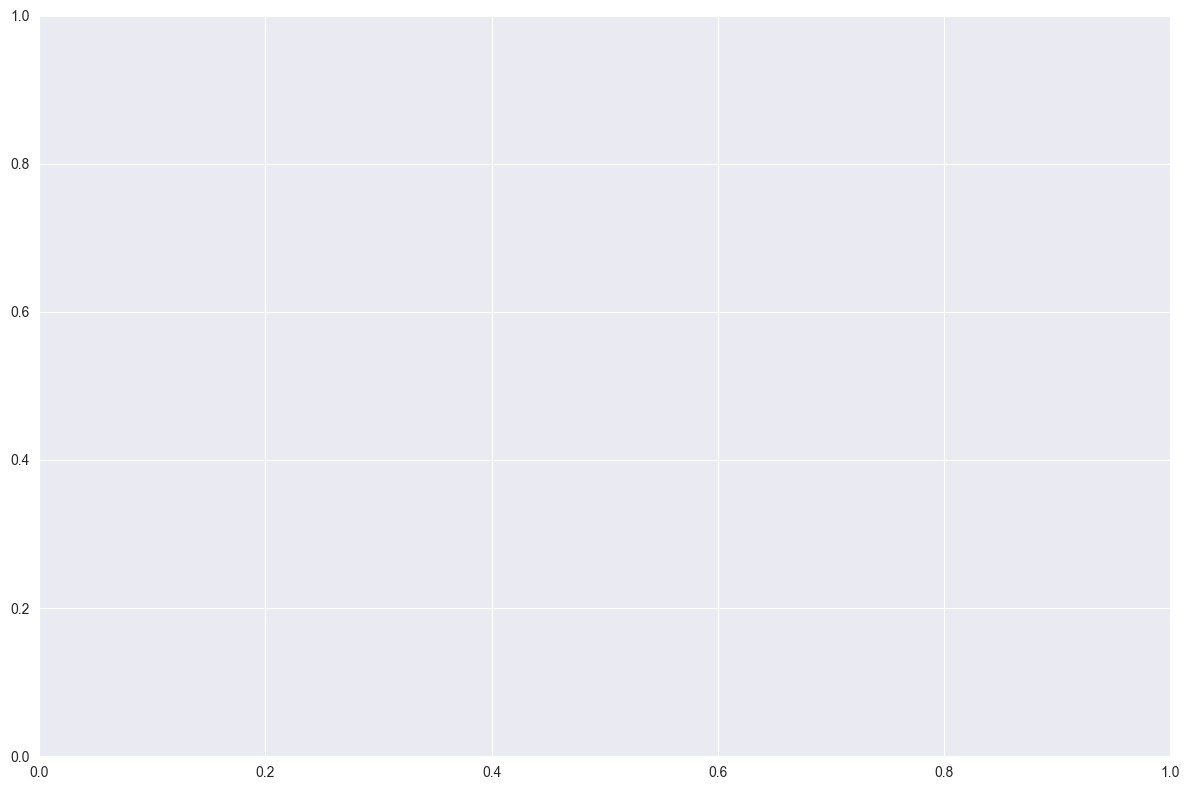

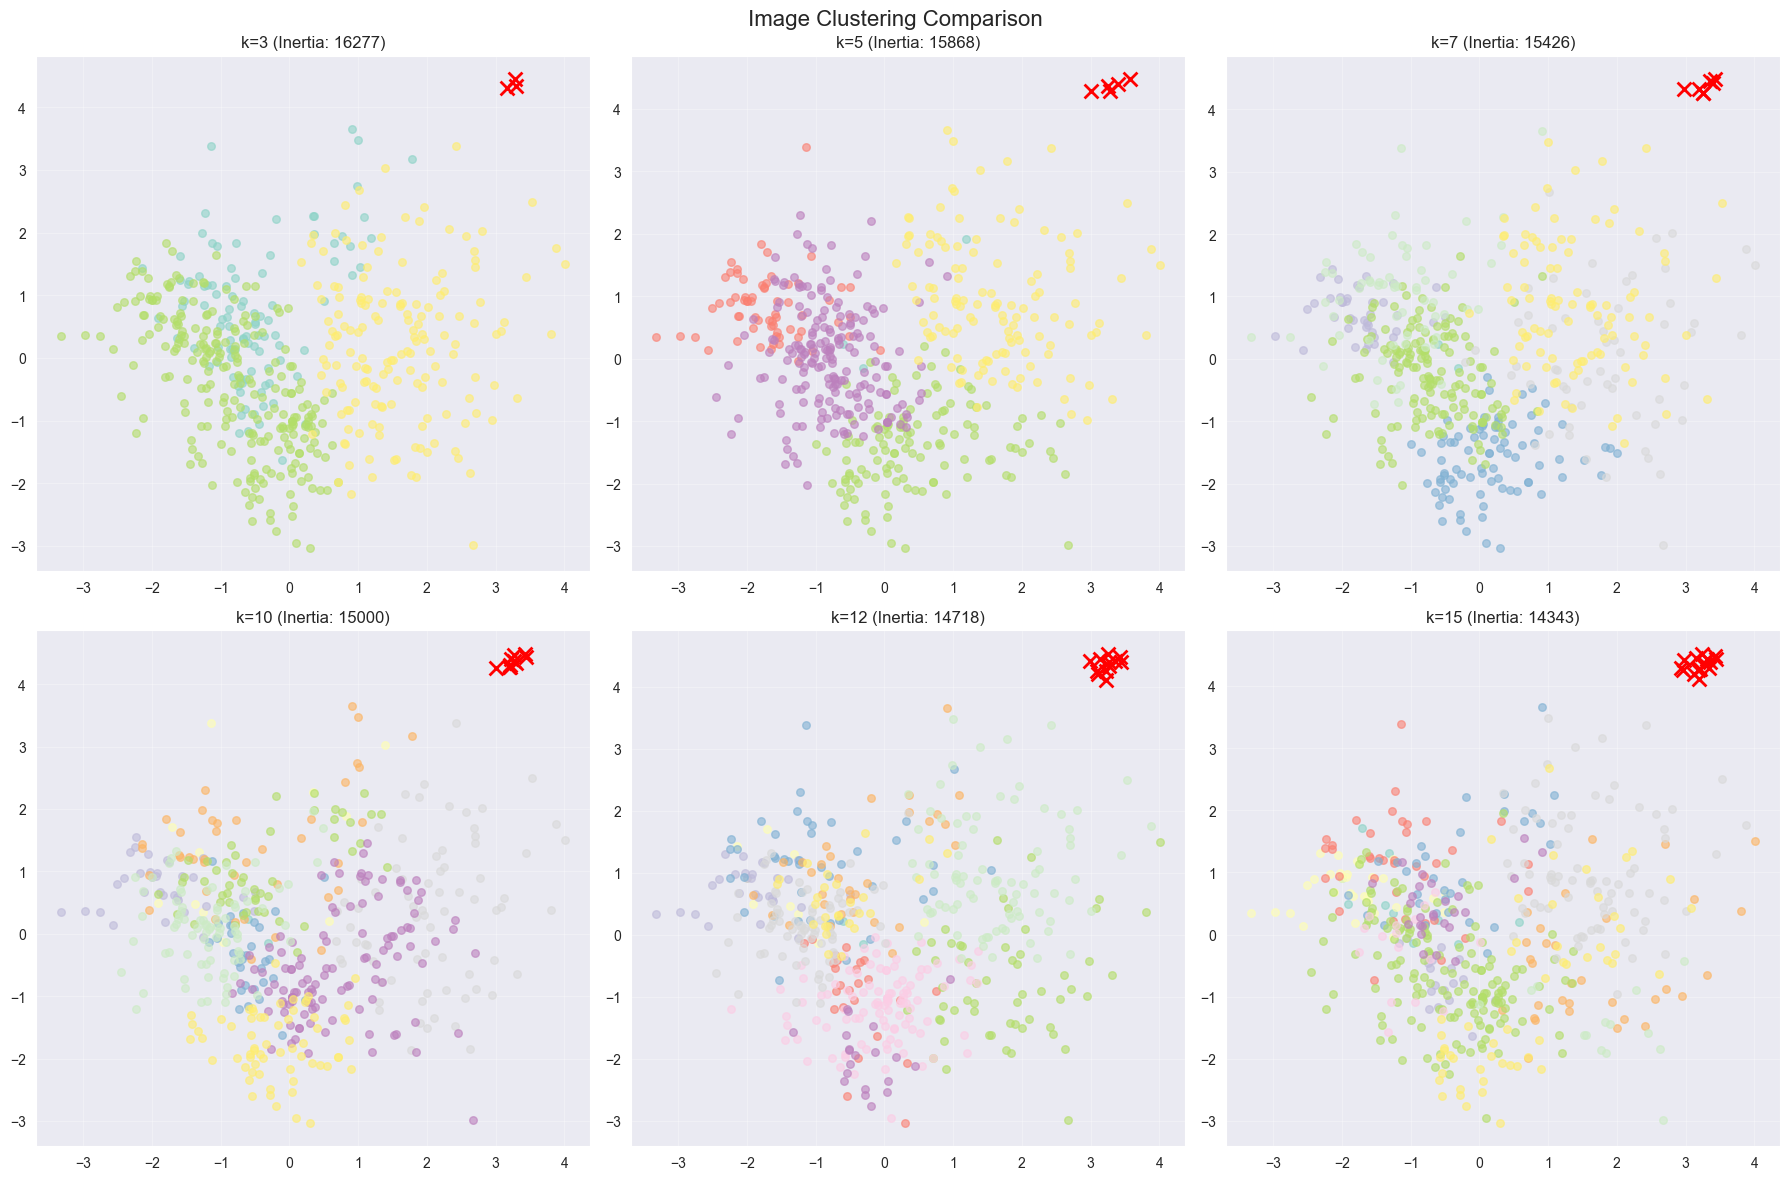


=== 클러스터 품질 평가 ===
k=2: Silhouette Score = 0.013
k=3: Silhouette Score = 0.025
k=4: Silhouette Score = 0.033
k=5: Silhouette Score = 0.027
k=6: Silhouette Score = 0.020
k=7: Silhouette Score = 0.020
k=8: Silhouette Score = 0.014
k=9: Silhouette Score = 0.017
k=10: Silhouette Score = 0.015


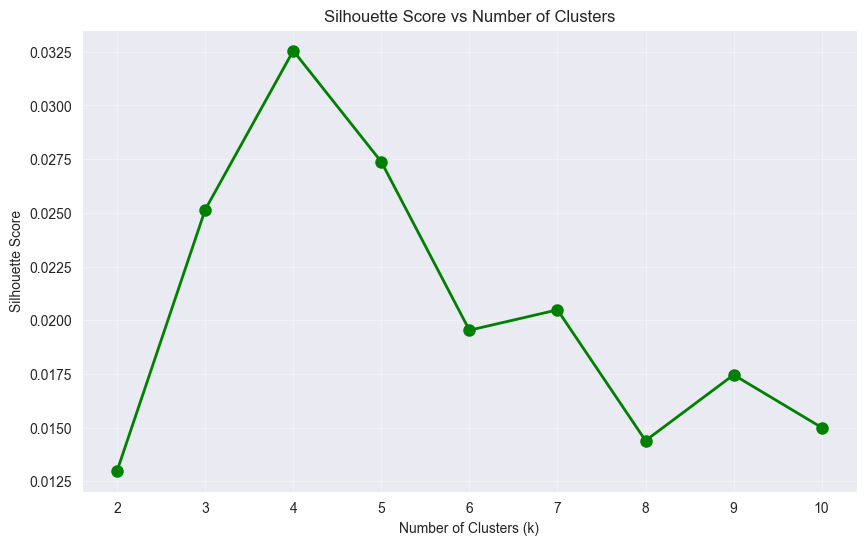


=== 최적 k 추천 ===
엘보우 방법 기준: k = 4
실루엣 스코어 기준: k = 4
클라이언트 수 기준: k = 5 (권장)


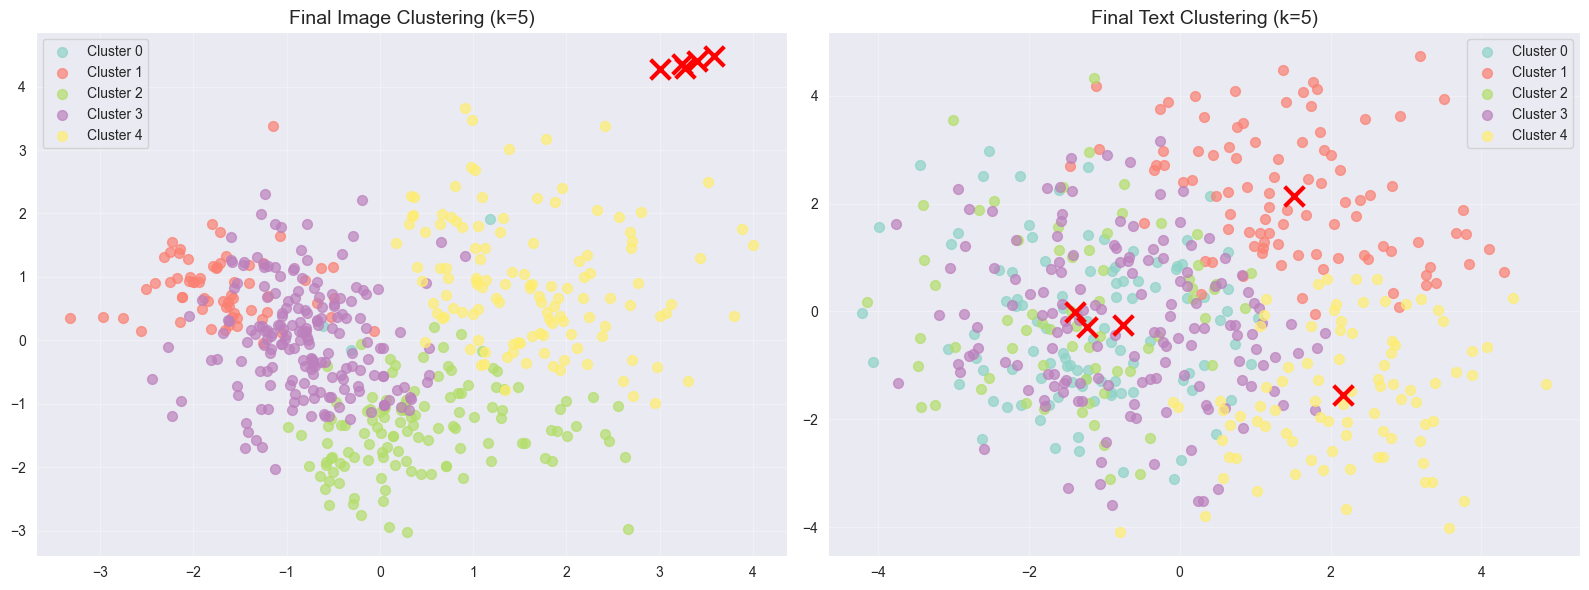


최종 클러스터링 완료! (k=5)
이미지 클러스터 분포: [  3  65 122 187 123]
텍스트 클러스터 분포: [104  94  67 148  87]


In [83]:
# KMeans 클러스터링 시각화 및 애니메이션
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from IPython.display import HTML

# 1. 엘보우 방법으로 최적 k 찾기
print("엘보우 방법으로 최적 k 찾는 중...")
inertias = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_reps)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}")

# 엘보우 그래프
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# 2. 2D 시각화를 위한 PCA 차원 축소
print("PCA 차원 축소 중...")
pca = PCA(n_components=2, random_state=42)
image_2d = pca.fit_transform(image_reps.numpy())
text_2d = pca.fit_transform(text_reps.numpy())

print(f"PCA 설명 분산 비율: {pca.explained_variance_ratio_}")
print(f"총 설명 분산: {pca.explained_variance_ratio_.sum():.3f}")

# 3. 다양한 k값에 대한 클러스터링 비교 애니메이션
def create_clustering_animation(data, title_prefix, k_values=[3, 5, 7, 10, 15]):
    """클러스터링 결과를 애니메이션으로 보여주는 함수"""

    fig, ax = plt.subplots(figsize=(12, 8))

    def animate(frame):
        ax.clear()
        k = k_values[frame % len(k_values)]

        # KMeans 실행
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        if title_prefix == "Image":
            labels = kmeans.fit_predict(image_reps)
            centers_2d = pca.transform(kmeans.cluster_centers_)
            data_2d = image_2d
        else:
            labels = kmeans.fit_predict(text_reps)
            centers_2d = pca.transform(kmeans.cluster_centers_)
            data_2d = text_2d

        # 클러스터별 색상 지정
        colors = plt.cm.Set3(np.linspace(0, 1, k))

        # 데이터 포인트 그리기
        for i in range(k):
            cluster_points = data_2d[labels == i]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=50)

        # 클러스터 중심점 그리기
        ax.scatter(centers_2d[:, 0], centers_2d[:, 1],
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')

        ax.set_title(f'{title_prefix} Clustering (k={k})', fontsize=16)
        ax.set_xlabel('PCA Component 1', fontsize=12)
        ax.set_ylabel('PCA Component 2', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    # 애니메이션 생성
    anim = animation.FuncAnimation(fig, animate, frames=len(k_values)*3,
                                 interval=1500, repeat=True)
    plt.tight_layout()
    return anim

# 4. 이미지 클러스터링 애니메이션
print("이미지 클러스터링 애니메이션 생성 중...")
img_anim = create_clustering_animation(image_2d, "Image")
plt.show()
HTML(img_anim.to_jshtml())

# 5. 텍스트 클러스터링 애니메이션
print("텍스트 클러스터링 애니메이션 생성 중...")
txt_anim = create_clustering_animation(text_2d, "Text")
plt.show()

# 6. 정적 비교 시각화 (여러 k값을 한 번에)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
k_values = [3, 5, 7, 10, 12, 15]

for idx, k in enumerate(k_values):
    row = idx // 3
    col = idx % 3

    # 이미지 클러스터링
    img_kmeans = KMeans(n_clusters=k, random_state=42)
    img_labels = img_kmeans.fit_predict(image_reps)

    # 클러스터별 색상
    colors = plt.cm.Set3(np.linspace(0, 1, k))

    for i in range(k):
        cluster_points = image_2d[img_labels == i]
        axes[row, col].scatter(cluster_points[:, 0], cluster_points[:, 1],
                              c=[colors[i]], alpha=0.6, s=30)

    # 중심점
    centers_2d = pca.transform(img_kmeans.cluster_centers_)
    axes[row, col].scatter(centers_2d[:, 0], centers_2d[:, 1],
                          c='red', marker='x', s=100, linewidths=2)

    axes[row, col].set_title(f'k={k} (Inertia: {img_kmeans.inertia_:.0f})')
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('Image Clustering Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# 7. 클러스터 품질 평가
from sklearn.metrics import silhouette_score

print("\n=== 클러스터 품질 평가 ===")
silhouette_scores = []

for k in range(2, 11):
    img_kmeans = KMeans(n_clusters=k, random_state=42)
    img_labels = img_kmeans.fit_predict(image_reps)
    score = silhouette_score(image_reps, img_labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.3f}")

# 실루엣 스코어 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# 8. 최종 권장 k값
best_k_elbow = k_range[np.argmax(np.diff(np.diff(inertias))) + 2]  # 엘보우 지점
best_k_silhouette = np.argmax(silhouette_scores) + 2

print(f"\n=== 최적 k 추천 ===")
print(f"엘보우 방법 기준: k = {best_k_elbow}")
print(f"실루엣 스코어 기준: k = {best_k_silhouette}")
print(f"클라이언트 수 기준: k = 5 (권장)")

# 9. 최종 선택된 k로 클러스터링 결과
final_k = 5  # 또는 위에서 계산된 최적값 사용

img_kmeans_final = KMeans(n_clusters=final_k, random_state=42)
txt_kmeans_final = KMeans(n_clusters=final_k, random_state=42)

img_labels_final = img_kmeans_final.fit_predict(image_reps)
txt_labels_final = txt_kmeans_final.fit_predict(text_reps)

# 최종 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set3(np.linspace(0, 1, final_k))

# 이미지 클러스터
for i in range(final_k):
    cluster_points = image_2d[img_labels_final == i]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

img_centers_2d = pca.transform(img_kmeans_final.cluster_centers_)
ax1.scatter(img_centers_2d[:, 0], img_centers_2d[:, 1],
           c='red', marker='x', s=200, linewidths=3)
ax1.set_title(f'Final Image Clustering (k={final_k})', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 텍스트 클러스터
for i in range(final_k):
    cluster_points = text_2d[txt_labels_final == i]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

txt_centers_2d = pca.transform(txt_kmeans_final.cluster_centers_)
ax2.scatter(txt_centers_2d[:, 0], txt_centers_2d[:, 1],
           c='red', marker='x', s=200, linewidths=3)
ax2.set_title(f'Final Text Clustering (k={final_k})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최종 클러스터링 완료! (k={final_k})")
print(f"이미지 클러스터 분포: {np.bincount(img_labels_final)}")
print(f"텍스트 클러스터 분포: {np.bincount(txt_labels_final)}")

In [84]:
k=5 # 절반 숫자로 일단 시작

img_kmeans = KMeans(n_clusters=k, random_state=42).fit(image_reps)
txt_kmeans = KMeans(n_clusters=k, random_state=42).fit(text_reps)

# 텍스트 클러스터 중심을 이미지 차원으로 투영
project_txt = torch.nn.Linear(text_reps.shape[1], image_reps.shape[1], bias=False)
with torch.no_grad():
    txt_proj_centers = project_txt(torch.tensor(txt_kmeans.cluster_centers_, dtype=torch.float32)).numpy()

dist_matrix = cdist(img_kmeans.cluster_centers_, txt_proj_centers, metric='cosine')
row_ind, col_ind = linear_sum_assignment(dist_matrix)

## Cross-attention-like 벡터 생성

In [85]:
paired_vectors = []
project_txt.eval()

for i, j in zip(row_ind, col_ind):
    img_cluster = image_reps[img_kmeans.labels_ == i]
    txt_cluster = text_reps[txt_kmeans.labels_ == j]

    mean_img = img_cluster.mean(dim=0)
    mean_txt = txt_cluster.mean(dim=0)
    mean_txt_proj = project_txt(mean_txt.unsqueeze(0)).squeeze(0)

    cross_attn_vec = F.normalize(mean_img + mean_txt_proj, dim=0)
    paired_vectors.append(cross_attn_vec)

In [86]:
print(f"[DEBUG] paired_vectors length: {len(paired_vectors)}")
for i, vec in enumerate(paired_vectors):
    print(f" - vector {i}: type={type(vec)}, shape={getattr(vec, 'shape', None)}")


[DEBUG] paired_vectors length: 5
 - vector 0: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 1: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 2: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 3: type=<class 'torch.Tensor'>, shape=torch.Size([512])
 - vector 4: type=<class 'torch.Tensor'>, shape=torch.Size([512])


##  Global Update Distribution with Gating

### constant 정의 및 평가 함수

In [87]:
# 상수 정의
GATING_RATIO = 0.3  # Gating 업데이트 비율 (0~1 사이)
UPDATED_MODEL_NAME = "gated_model.pt"  # 업데이트된 모델 저장 이름

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            # 변수 초기화를 맨 앞에
            images = None
            texts = None
            labels = None

            try:
                if isinstance(batch, list) and len(batch) == 4:
                    images = batch[0]
                    text_input_ids = batch[1]
                    text_attention_mask = batch[2]
                    labels = batch[3]

                    texts = {
                        'input_ids': text_input_ids,
                        'attention_mask': text_attention_mask
                    }

                elif isinstance(batch, dict):
                    images = batch.get('image', None)
                    texts = batch.get('text', None)
                    labels = batch['label']
                elif len(batch) == 3:
                    images, texts, labels = batch
                elif len(batch) == 2:
                    data, labels = batch
                    images = data
                    texts = None
                else:
                    print(f"Unexpected batch structure: length={len(batch)}, types={[type(x) for x in batch]}")
                    continue

            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

            # GPU로 이동
            device = next(model.parameters()).device
            if images is not None:
                images = images.to(device)
            if texts is not None:
                if isinstance(texts, dict):
                    texts = {k: v.to(device) for k, v in texts.items()}
                elif hasattr(texts, 'to'):
                    texts = texts.to(device)
            labels = labels.to(device)

            # 순전파
            try:
                has_img = hasattr(model, 'use_img') and model.use_img
                has_txt = hasattr(model, 'use_txt') and model.use_txt

                # batch_size 결정
                if images is not None:
                    batch_size = images.size(0)
                elif texts is not None and isinstance(texts, dict):
                    batch_size = texts['input_ids'].size(0)
                else:
                    print("Warning: Cannot determine batch size")
                    continue

                # prev_z 초기화
                prev_z = torch.zeros(batch_size, 256).to(device)

                if has_img and has_txt and images is not None and texts is not None:
                    input_ids = texts['input_ids']
                    attention_mask = texts['attention_mask']
                    outputs, _ = model(images, input_ids, attention_mask, prev_z)

                elif has_img and images is not None:
                    outputs, _ = model(images, None, None, prev_z)

                elif has_txt and texts is not None:
                    input_ids = texts['input_ids']
                    attention_mask = texts['attention_mask']
                    outputs, _ = model(None, input_ids, attention_mask, prev_z)

                else:
                    print("Warning: No matching input modality found")
                    continue

            except Exception as e:
                print(f"Error in model forward pass: {e}")
                print(f"Model attributes: use_img={getattr(model, 'use_img', 'unknown')}, use_txt={getattr(model, 'use_txt', 'unknown')}")
                continue

            # 손실 계산
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if len(data_loader) == 0 or total == 0:
        return 0.0, 0.0

    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

### gating mechanism

In [88]:
from collections import OrderedDict

paired_vectors = torch.stack(list(paired_vectors)).to(device)
NUM_CLIENTS = 10
CLIENT_ROOT = 'clients'

before_acc_list = []
after_acc_list = []

for cid in range(NUM_CLIENTS):
    client_path = os.path.join(CLIENT_ROOT, f"client_{cid}")
    model_path = os.path.join(client_path, "best_model.pt")

    if not os.path.exists(model_path):
        print(f"[경고] Client {cid}에 best_model.pt 없음")
        continue

    # 라벨 개수 추정
    train_dir = os.path.join(client_path, "train")
    labels = sorted([l for l in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, l))])
    label2idx = {label: idx for idx, label in enumerate(labels)}
    num_classes = len(label2idx)

    # ===== 핵심 수정 부분 =====
    # 저장된 모델에서 실제 fusion_input_dim 추출
    saved_state = torch.load(model_path, map_location=device)
    actual_fusion_input_dim = saved_state['fc_fusion.weight'].shape[1]

    print(f"[DEBUG] Client {cid}: 저장된 모델의 실제 fusion_input_dim = {actual_fusion_input_dim}")

    # use_img/use_txt 설정
    use_img = (cid not in [2, 3])
    use_txt = (cid not in [0, 1])

    # 실제 차원으로 모델 생성
    model = FusionClassifier(actual_fusion_input_dim, 256, num_classes,
                             use_img=use_img, use_txt=use_txt).to(device)

    # 이제 차원이 맞으므로 정상 로드됨
    model.load_state_dict(saved_state)
    # ========================

    # 클라이언트 로컬 validation 데이터셋으로 평가
    val_dir = os.path.join(client_path, "val")
    val_ds = MultiModalDataset(
        root=val_dir,
        tokenizer=AutoTokenizer.from_pretrained("prajjwal1/bert-tiny"),
        transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
        label2idx=label2idx
    )
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16)

    criterion = torch.nn.CrossEntropyLoss()

    _, before_acc = evaluate(model, val_loader, criterion)
    before_acc_list.append(before_acc)

    # Gating 업데이트
    updated_state = OrderedDict()
    global_rep = paired_vectors[cid % len(paired_vectors)]

    for name, param in model.state_dict().items():
        if name.endswith("fc_fusion.weight") or name.endswith("input_gate.weight"):
            out_dim, in_dim = param.shape
            projected = global_rep[:out_dim].unsqueeze(1).expand(out_dim, in_dim)
            updated_param = (1 - GATING_RATIO) * param + GATING_RATIO * projected
        else:
            updated_param = param
        updated_state[name] = updated_param

    model.load_state_dict(updated_state)
    _, after_acc = evaluate(model, val_loader, criterion)
    after_acc_list.append(after_acc)

    torch.save(updated_state, os.path.join(client_path, UPDATED_MODEL_NAME))
    print(f"Client {cid}: Updated (Before={before_acc:.4f}, After={after_acc:.4f})")


C:\Users\user\AppData\Local\Temp\ipykernel_30620\1809677251.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(model_path, map_location=device)
C:

[DEBUG] Client 0: 저장된 모델의 실제 fusion_input_dim = 576
Client 0: Updated (Before=97.3333, After=94.6667)
[DEBUG] Client 1: 저장된 모델의 실제 fusion_input_dim = 576
Client 1: Updated (Before=80.0000, After=74.6667)
[DEBUG] Client 2: 저장된 모델의 실제 fusion_input_dim = 128
Client 2: Updated (Before=94.6667, After=93.3333)
[DEBUG] Client 3: 저장된 모델의 실제 fusion_input_dim = 128
Client 3: Updated (Before=90.6667, After=90.6667)
[DEBUG] Client 4: 저장된 모델의 실제 fusion_input_dim = 704
Client 4: Updated (Before=84.0000, After=89.3333)
[DEBUG] Client 5: 저장된 모델의 실제 fusion_input_dim = 704
Client 5: Updated (Before=93.3333, After=82.6667)
[DEBUG] Client 6: 저장된 모델의 실제 fusion_input_dim = 704
Client 6: Updated (Before=85.3333, After=72.0000)
[DEBUG] Client 7: 저장된 모델의 실제 fusion_input_dim = 704
Client 7: Updated (Before=96.0000, After=96.0000)
[DEBUG] Client 8: 저장된 모델의 실제 fusion_input_dim = 704
Client 8: Updated (Before=93.3333, After=94.6667)
[DEBUG] Client 9: 저장된 모델의 실제 fusion_input_dim = 704
Client 9: Updated (Before=94.6

## 시각화

In [89]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [90]:
import matplotlib.pyplot as plt

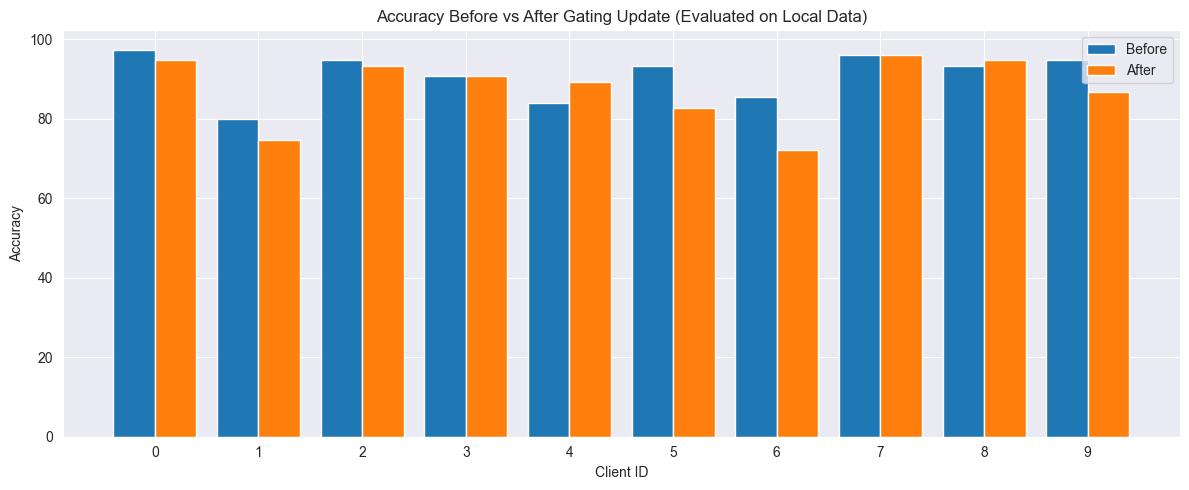

In [91]:
plt.figure(figsize=(12, 5))
x = list(range(NUM_CLIENTS))
plt.bar([i - 0.2 for i in x], before_acc_list, width=0.4, label="Before")
plt.bar([i + 0.2 for i in x], after_acc_list, width=0.4, label="After")
plt.xticks(x)
plt.xlabel("Client ID")
plt.ylabel("Accuracy")
plt.title("Accuracy Before vs After Gating Update (Evaluated on Local Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()